In [1]:
print("hello")

hello


Using device: cuda


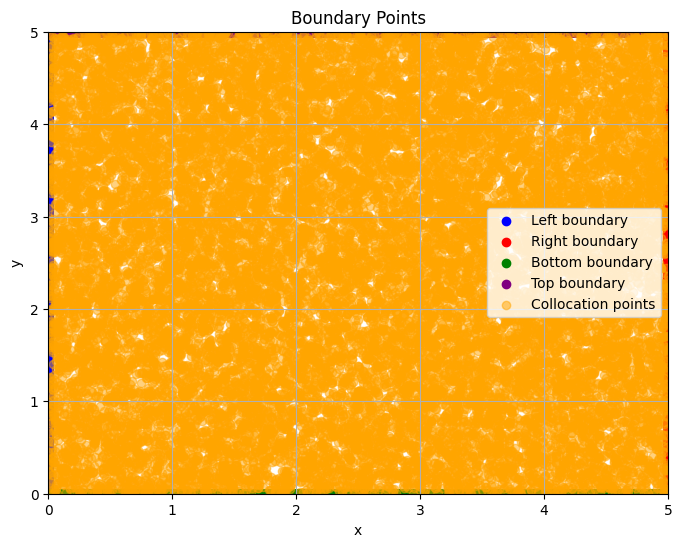

Left boundary: tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<ToCopyBackward0>) tensor([[1.8727],
        [4.7536],
        [3.6600],
        ...,
        [4.3279],
        [4.9037],
        [2.0379]], device='cuda:0', grad_fn=<ToCopyBackward0>) tensor([[0.8275],
        [0.7645],
        [0.5735],
        ...,
        [0.3278],
        [0.8157],
        [0.5973]], device='cuda:0', grad_fn=<ToCopyBackward0>)
Right boundary: tensor([[5.],
        [5.],
        [5.],
        ...,
        [5.],
        [5.],
        [5.]], device='cuda:0', grad_fn=<ToCopyBackward0>) tensor([[1.9682],
        [2.3672],
        [4.2727],
        ...,
        [4.2516],
        [1.0643],
        [3.3438]], device='cuda:0', grad_fn=<ToCopyBackward0>) tensor([[0.5429],
        [0.8329],
        [0.1251],
        ...,
        [0.9467],
        [0.3975],
        [0.2171]], device='cuda:0', grad_fn=<ToCopyBackward0>)
Bottom boundary: tens

/home/iitgn-robotics-1/Desktop/Temperature Field Prediction 3D/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epochs: 100 Total Loss: 47425561559040.0 Ic loss: 1080.64404296875 Top Loss: 0.004301091656088829 Left Loss: 0.15945927798748016 Right loss: 6.5177046053577214e-06 Bottom loss: 0.11401132494211197 Inside Loss: 47425561559040.0 device cuda
Epochs: 200 Total Loss: 47456448413696.0 Ic loss: 1291.7296142578125 Top Loss: 1.9307632825871224e-08 Left Loss: 1.803642390996174e-08 Right loss: 2.5896233074584885e-11 Bottom loss: 2.3797106646350485e-11 Inside Loss: 47456448413696.0 device cuda
Epochs: 300 Total Loss: 47456448413696.0 Ic loss: 1284.3458251953125 Top Loss: 1.9137447182515643e-08 Left Loss: 1.7835887433648168e-08 Right loss: 2.5701649142284566e-11 Bottom loss: 2.3274757121605205e-11 Inside Loss: 47456448413696.0 device cuda
Epochs: 400 Total Loss: 47456448413696.0 Ic loss: 1277.008544921875 Top Loss: 1.9162403219752377e-08 Left Loss: 1.785927850050939e-08 Right loss: 2.5737755676713547e-11 Bottom loss: 2.3309501898105545e-11 Inside Loss: 47456448413696.0 device cuda
Epochs: 500 Total

KeyboardInterrupt: 

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Given parameters
delta_T = 50 # K
rb_star = 20e-6 # m
lc = rb_star
rb = rb_star / lc
A_star = 0.1
P_star = 100 # W
domain_size_star = 100e-6 # m
domain_size = domain_size_star / lc
T_s_star = 1878 # K
T_l_star = 1928 # K
rho__star = 3730 # kg/m^3
Cp_star = 830  # J/kgK
k_star = 33 # W/mK
alph_diff_star = k_star / (rho__star * Cp_star)
k_cap = 4.02
Lamda = 1.08e-6
alpha_star = 4 * np.pi * k_cap / Lamda
alpha_c = alpha_star
alpha = alpha_star / alpha_c

tau = 5e-6
t_star_max = 5e-6
t_max = t_star_max/tau

x_max_star = domain_size_star
x_max = x_max_star / lc

y_max_star = domain_size_star
y_max = y_max_star / lc

class PhysicsInformedNN():
    def __init__(self, X_ic, X_b, X_f):
        # Extracting and printing left boundary points
        self.x_left = torch.tensor(X_b[X_b[:, 0] == 0, 0].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.y_left = torch.tensor(X_b[X_b[:, 0] == 0, 1].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.t_left = torch.tensor(X_b[X_b[:, 0] == 0, 2].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        print('Left boundary:', self.x_left, self.y_left, self.t_left)

        # Extracting and printing right boundary points
        self.x_right = torch.tensor(X_b[X_b[:, 0] == domain_size, 0].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.y_right = torch.tensor(X_b[X_b[:, 0] == domain_size, 1].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.t_right = torch.tensor(X_b[X_b[:, 0] == domain_size, 2].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        print('Right boundary:', self.x_right, self.y_right, self.t_right)

        # Extracting and printing bottom boundary points
        self.x_bottom = torch.tensor(X_b[X_b[:, 1] == domain_size, 0].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.y_bottom = torch.tensor(X_b[X_b[:, 1] == domain_size, 1].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.t_bottom = torch.tensor(X_b[X_b[:, 1] == domain_size, 2].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        print('Bottom boundary:', self.x_bottom, self.y_bottom, self.t_bottom)

        # Extracting and printing top boundary points
        self.x_top = torch.tensor(X_b[X_b[:, 1] == 0, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)
        self.y_top = torch.tensor(X_b[X_b[:, 1] == 0, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)
        self.t_top = torch.tensor(X_b[X_b[:, 1] == 0, 2].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)
        print('Top boundary:', self.x_top, self.y_top, self.y_top)

        # Extracting and printing collocation points
        self.x_f = torch.tensor(X_f[:, 0].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        self.y_f = torch.tensor(X_f[:, 1].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        self.t_f = torch.tensor(X_f[:, 2].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        print('Collocation points:', self.x_f, self.y_f, self.t_f)


        
        #initial_condition

        self.x_ic = torch.tensor(X_ic[:, 0].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        self.y_ic = torch.tensor(X_ic[:, 1].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        self.t_ic = torch.tensor(X_ic[:, 2].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        print('initial points:', self.x_ic, self.y_ic, self.t_ic)
        # self.x_ic = torch.vstack((self.x_left, self.x_right, self.x_top, self.x_bottom, self.x_f)).to(device)
        # self.y_ic = torch.vstack((self.y_left,self.y_right, self.y_top, self.y_bottom, self.y_f)).to(device)
        # self.t_ic = torch.zeros((self.x_ic.shape[0], 1), dtype=torch.float32).to(device)
        self.theta_ic = torch.full((self.x_ic.shape[0], 1), -31, dtype=torch.float32).to(device)

         # Null vector to test against left:
        self.left_null = torch.zeros((self.x_left.shape[0], 1), dtype=torch.float32).to(device)
        self.top_null = torch.zeros((self.x_top.shape[0], 1), dtype=torch.float32).to(device)
        self.right_null = torch.zeros((self.x_right.shape[0], 1), dtype=torch.float32).to(device)
        self.right_null = torch.zeros((self.x_bottom.shape[0], 1), dtype=torch.float32).to(device)

        self.null = torch.zeros((self.x_f.shape[0], 1), dtype=torch.float32).to(device)
        
        self.create_net()

        self.optimizer1 = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        self.optimizer = torch.optim.LBFGS(self.net.parameters(),
                                    lr=1,
                                    max_iter=50000,
                                    max_eval=50000,
                                    history_size=50,
                                    tolerance_grad=1e-05,
                                    tolerance_change=0.5 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")
        self.iter = 0
        self.losses = []
        self.ic_losses = []
        self.top_losses = []
        self.left_losses = []
        self.right_losses = []
        self.bottom_losses = []
        self.inside_losses = []
        self.loss = nn.MSELoss()
        
    def create_net(self):
        self.net = nn.Sequential(
            nn.Linear(3, 40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40, 1)
        ).to(device)

    def net_theta(self,x,y,t):
        theta = self.net(torch.hstack((x,y,t)))
        return theta
    
    def net_bc(self, x, y, t):
        theta = self.net_theta(x,y,t)
        theta_x = torch.autograd.grad(theta, x, torch.ones_like(theta), create_graph=True)[0]
        theta_y = torch.autograd.grad(theta, y, torch.ones_like(theta), create_graph=True)[0]
        bc = theta_x + theta_y
        return bc
    
    
    def net_inside(self, x, y, t):
        theta = self.net_theta(x,y,t)
        
        theta_t = torch.autograd.grad(theta, t, torch.ones_like(theta), create_graph=True)[0]
        theta_x = torch.autograd.grad(theta, x, torch.ones_like(theta), create_graph=True)[0]
        theta_xx = torch.autograd.grad(theta_x, x, torch.ones_like(theta_x), create_graph=True)[0]
        theta_y = torch.autograd.grad(theta, y, torch.ones_like(theta), create_graph=True)[0]
        theta_yy = torch.autograd.grad(theta_y, y, torch.ones_like(theta_y), create_graph=True)[0]
        
        term1 = ((tau * 2 * A_star * P_star * alpha_c * alpha)/(k_star*delta_T*np.pi*(lc**2)*(rb**2)))
        term2 = torch.exp(-2*(x**2 + (y - y_max)**2/rb**2))
        term3 = torch.exp(-alpha_c*alpha*lc*abs(y-y_max))
        Q_0 =  term1 * term2 * term3
        
        net_inside = -(1/alph_diff_star)*theta_t + (tau/lc**2)*(theta_xx + theta_yy) + Q_0
        return net_inside
    
    def closure(self):
        # Reset gradient to zero
        self.optimizer.zero_grad()

        # T prediction at boundary points and collocation points
        theta_ic_prediction = self.net_theta(self.x_ic,self.y_ic,self.t_ic)
        theta_left_prediction = self.net_bc(self.x_left, self.y_left,self.t_left)
        theta_top_prediction = self.net_bc(self.x_top, self.y_top, self.t_top)
        theta_right_prediction = self.net_bc(self.x_right, self.y_right, self.t_right)
        theta_bottom_prediction = self.net_bc(self.x_bottom, self.y_bottom, self.t_bottom)

        # ic loss
        
        theta_ic_loss = self.loss(theta_ic_prediction, self.theta_ic) 
        # Temperature gradient and losses for the inside condition
        theta_inside_prediction = self.net_inside(self.x_f, self.y_f, self.t_f)
        theta_loss_inside = self.loss(theta_inside_prediction, self.null)

        # losses for the boundary conditions
        theta_left_loss = self.loss(theta_left_prediction, self.left_null)
        theta_top_loss = self.loss(theta_top_prediction, self.top_null)
        theta_right_loss = self.loss(theta_right_prediction, self.right_null)
        theta_bottom_loss = self.loss(theta_bottom_prediction, self.right_null)

        self.ls = theta_ic_loss + theta_top_loss + theta_left_loss + theta_right_loss + theta_bottom_loss + theta_loss_inside
        self.losses.append(self.ls.item())
        self.ic_losses.append(theta_ic_loss.item())
        self.top_losses.append(theta_top_loss.item())
        self.left_losses.append(theta_left_loss.item())
        self.right_losses.append(theta_right_loss.item())
        self.bottom_losses.append(theta_bottom_loss.item())
        self.inside_losses.append(theta_loss_inside.item())

        # Check for NaN values
        if torch.isnan(self.ls):
            print("Loss is NaN. Stopping training.")
            return self.ls

        # derivative with respect to net's weights
        self.ls.backward()
        # self.optimizer.step()
        # increase iteration count
        self.iter += 1

        # print report:
        if not self.iter % 100:
            print(f"Epochs: {self.iter} Total Loss: {self.ls} Ic loss: {theta_ic_loss} Top Loss: {theta_top_loss} Left Loss: {theta_left_loss} Right loss: {theta_right_loss} Bottom loss: {theta_bottom_loss} Inside Loss: {theta_loss_inside}device {device}")

        return self.ls

    def closure1(self):
        # Reset gradient to zero
        self.optimizer.zero_grad()

        # T prediction at boundary points and collocation points
        theta_ic_prediction = self.net_theta(self.x_ic,self.y_ic,self.t_ic)
        theta_left_prediction = self.net_bc(self.x_left, self.y_left,self.t_left)
        theta_top_prediction = self.net_bc(self.x_top, self.y_top, self.t_top)
        theta_right_prediction = self.net_bc(self.x_right, self.y_right, self.t_right)
        theta_bottom_prediction = self.net_bc(self.x_bottom, self.y_bottom, self.t_bottom)

        # ic loss
        
        theta_ic_loss = self.loss(theta_ic_prediction, self.theta_ic)
        # Temperature gradient and losses for the inside condition
        theta_inside_prediction = self.net_inside(self.x_f, self.y_f, self.t_f)
        theta_loss_inside = self.loss(theta_inside_prediction, self.null)

        # losses for the boundary conditions
        theta_left_loss = self.loss(theta_left_prediction, self.left_null)
        theta_top_loss = self.loss(theta_top_prediction, self.top_null)
        theta_right_loss = self.loss(theta_right_prediction, self.right_null)
        theta_bottom_loss = self.loss(theta_bottom_prediction, self.right_null)

        self.ls = theta_ic_loss + theta_top_loss + theta_left_loss + theta_right_loss + theta_bottom_loss + theta_loss_inside
        self.losses.append(self.ls.item())
        self.ic_losses.append(theta_ic_loss.item())
        self.top_losses.append(theta_top_loss.item())
        self.left_losses.append(theta_left_loss.item())
        self.right_losses.append(theta_right_loss.item())
        self.bottom_losses.append(theta_bottom_loss.item())
        self.inside_losses.append(theta_loss_inside.item())

        # Check for NaN values
        if torch.isnan(self.ls):
            print("Loss is NaN. Stopping training.")
            return self.ls

        # derivative with respect to net's weights
        self.ls.backward()
        self.optimizer1.step()
        # increase iteration count
        self.iter += 1

        # print report:
        if not self.iter % 100:
            print(f"Epochs: {self.iter} Total Loss: {self.ls} Ic loss: {theta_ic_loss} Top Loss: {theta_top_loss} Left Loss: {theta_left_loss} Right loss: {theta_right_loss} Bottom loss: {theta_bottom_loss} Inside Loss: {theta_loss_inside} device {device}")

        return self.ls
    
    def train(self, epochs = 10000):
        self.net.train()
        
        for _ in range(epochs):
            self.closure1()
        self.optimizer.step(self.closure)      
        self.plot_losses()
        
    def predict(self,x,y,t):
        self.net.eval()
        x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        y = torch.tensor(y, dtype=torch.float32, requires_grad=True)
        t = torch.tensor(t, dtype=torch.float32,requires_grad=True)
        theta = self.net_theta(x,y,t)
        return theta
    
    def save_model(self, file_path):
      torch.save(self.net.state_dict(), file_path)

    def load_model(self, file_path):
      self.net.load_state_dict(torch.load(file_path))
    

    def plot_losses(self):
        
        plt.figure(figsize=(10, 6))
        plt.plot(self.losses, label='Total Loss', color='blue')
        plt.plot(self.ic_losses, label='IC Loss', color='red')
        plt.plot(self.top_losses, label='Top BC Loss', color='green')
        plt.plot(self.left_losses, label='Left BC Loss', color='purple')
        plt.plot(self.right_losses, label='Right BC Loss', color='orange')
        plt.plot(self.bottom_losses, label='Bottom BC Loss', color='brown')
        plt.plot(self.inside_losses, label='PDE Loss', color='pink')
        plt.yscale('log')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.savefig('lossvepoch.png')
        # epochs = range(len(self.losses))
        # fig, axs = plt.subplots(2, 3, figsize=(15, 10))

        # axs[0, 0].plot(epochs, self.ic_losses, label='IC Loss')
        # axs[0, 0].set_title('IC Loss')
        # axs[0, 0].set_xlabel('Epochs')
        # axs[0, 0].set_ylabel('Loss')
        # axs[0, 0].legend()

        # axs[0, 1].plot(epochs, self.top_losses, label='Top Loss')
        # axs[0, 1].set_title('Top Loss')
        # axs[0, 1].set_xlabel('Epochs')
        # axs[0, 1].set_ylabel('Loss')
        # axs[0, 1].legend()

        # axs[0, 2].plot(epochs, self.left_losses, label='Left Loss')
        # axs[0, 2].set_title('Left Loss')
        # axs[0, 2].set_xlabel('Epochs')
        # axs[0, 2].set_ylabel('Loss')
        # axs[0, 2].legend()

        # axs[1, 0].plot(epochs, self.right_losses, label='Right Loss')
        # axs[1, 0].set_title('Right Loss')
        # axs[1, 0].set_xlabel('Epochs')
        # axs[1, 0].set_ylabel('Loss')
        # axs[1, 0].legend()

        # axs[1, 1].plot(epochs, self.bottom_losses, label='Bottom Loss')
        # axs[1, 1].set_title('Bottom Loss')
        # axs[1, 1].set_xlabel('Epochs')
        # axs[1, 1].set_ylabel('Loss')
        # axs[1, 1].legend()

        # axs[1, 2].plot(epochs, self.inside_losses, label='Inside Loss')
        # axs[1, 2].set_title('Inside Loss')
        # axs[1, 2].set_xlabel('Epochs')
        # axs[1, 2].set_ylabel('Loss')
        # axs[1, 2].legend()

        # plt.tight_layout()
        # plt.show()
            
    
    
if __name__ == "__main__":
    N_theta = 10000
    N_F = 20000

    
    
    
    # Left boundary
    x_left_star = np.zeros((N_theta//4, 1), dtype=float)
    y_left_star = np.random.uniform(0, domain_size_star, (N_theta//4, 1))
    t_left_star = np.random.uniform(0, t_star_max, (N_theta//4, 1))

    x_left = x_left_star / lc
    y_left = y_left_star / lc
    t_left = t_left_star / tau


    # Right boundary
    x_right_star = np.full((N_theta//4, 1), domain_size_star, dtype=float)
    y_right_star = np.random.uniform(0, domain_size_star, (N_theta//4, 1))
    t_right_star = np.random.uniform(0, t_star_max, (N_theta//4, 1))

    x_right = x_right_star / lc
    y_right = y_right_star / lc
    t_right = t_right_star / tau


    
    # Bottom boundary
    x_bottom_star = np.random.uniform(0, domain_size_star, (N_theta//4, 1))
    y_bottom_star = np.zeros((N_theta//4, 1), dtype=float)
    t_bottom_star = np.random.uniform(0, t_star_max, (N_theta//4, 1))

    x_bottom = x_bottom_star / lc
    y_bottom = y_bottom_star / lc
    t_bottom = t_bottom_star / tau

    # Top boundary
    x_top_star = np.random.uniform(0, domain_size_star, (N_theta//4, 1))
    y_top_star = np.full((N_theta//4, 1), domain_size_star, dtype=float)
    t_top_star = np.random.uniform(0, t_star_max, (N_theta//4, 1))

    x_top = x_top_star / lc
    y_top = y_top_star / lc
    t_top = t_top_star / tau

    # collocation points
    x_f_star = np.random.uniform(0, domain_size_star, (N_F, 1))
    y_f_star = np.random.uniform(0, domain_size_star, (N_F, 1))
    t_f_star = np.random.uniform(0, t_star_max, (N_F, 1))

    x_f = x_f_star / lc
    y_f = y_f_star / lc
    t_f = t_f_star / tau

   
    
    # stacking the datapoints for training
    
    '''
    boundary points:
    '''
    x_b = np.vstack((x_left, x_right, x_bottom, x_top))    
    y_b = np.vstack((y_left, y_right, y_bottom, y_top))
    t_b = np.vstack((t_left, t_right, t_bottom, t_top))
    X_b = np.hstack((x_b, y_b, t_b))
    
    '''
    collocation points:
    '''
    x_f = x_f.reshape(-1, 1)
    y_f = y_f.reshape(-1, 1)
    t_f = t_f.reshape(-1, 1)
    X_f = np.hstack((x_f, y_f, t_f))

    # initial condition
    x_ic = np.vstack((x_b,x_f))
    y_ic = np.vstack((y_b, y_f))
    t_ic = np.full_like(x_ic, 0.0)

    X_ic = np.hstack((x_ic,y_ic, t_ic))
    
    # Plot the points with different colors for each boundary
    plt.figure(figsize=(8, 6))
    plt.scatter(x_left, y_left, c='blue', label='Left boundary')
    plt.scatter(x_right, y_right, c='red', label='Right boundary')
    plt.scatter(x_bottom, y_bottom, c='green', label='Bottom boundary')
    plt.scatter(x_top, y_top, c='purple', label='Top boundary')
    plt.scatter(x_f, y_f, c='orange', label='Collocation points', alpha=0.5)
    plt.xlim(0, domain_size)
    plt.ylim(0, domain_size)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Boundary Points')
    plt.legend()
    plt.grid(True)
    plt.show()


    pinn = PhysicsInformedNN(X_ic, X_b, X_f)
    pinn.train()
    pinn.save_model('model-0.pth')
    # pinn.load_model('model-0.pth')


In [ ]:
!python3 -m pip install typing_extensions -U --force-reinstall

: 

/home/iitgn-robotics-1/.local/lib/python3.8/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/iitgn-robotics-1/.local/lib/python3.8/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


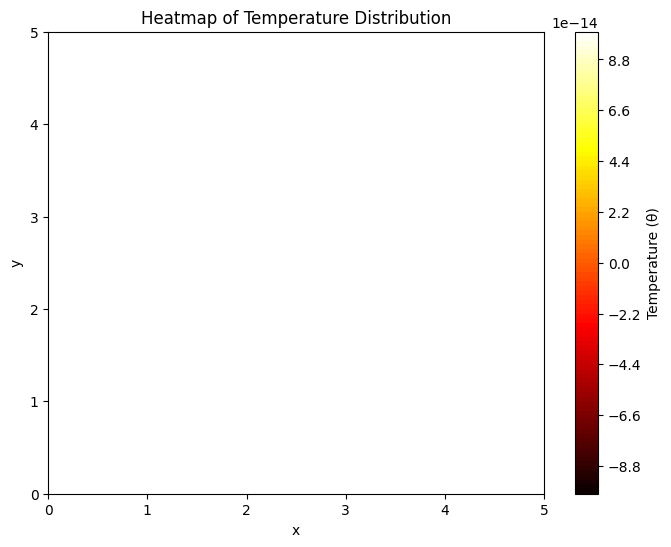

In [11]:
# Set the grid size for the heatmap
n_grid = 100
x_grid = np.linspace(0, domain_size, n_grid)
y_grid = np.linspace(0, domain_size, n_grid)
X, Y = np.meshgrid(x_grid, y_grid)

# Flatten the grid arrays to create input arrays for the model
x_flat = X.flatten()
y_flat = Y.flatten()
t_flat = np.full_like(x_flat, t_max)  # Assuming we want to plot at the final time step

# Convert to torch tensors and move to the same device as the model
x_flat_tensor = torch.tensor(x_flat, dtype=torch.float32, device=device).reshape(-1, 1)
y_flat_tensor = torch.tensor(y_flat, dtype=torch.float32, device=device).reshape(-1, 1)
t_flat_tensor = torch.tensor(t_flat, dtype=torch.float32, device=device).reshape(-1, 1)

# Use the model to predict temperature at each point in the grid
with torch.no_grad():
    theta_pred = pinn.net_theta(x_flat_tensor, y_flat_tensor, t_flat_tensor)

# Reshape the predictions to match the grid shape
Theta = theta_pred.cpu().numpy().reshape(n_grid, n_grid)

# Plot the heatmap
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Theta, cmap='hot', levels=100)
plt.colorbar(contour, label='Temperature (θ)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heatmap of Temperature Distribution')
plt.show()


/home/iitgn-robotics-1/Desktop/Temperature Field Prediction 3D/.venv/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0, Loss: 0.17230981588363647


KeyboardInterrupt: 

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        ).to(device)
    
    def forward(self, x, y, t):
        inputs = torch.cat([x, y, t], dim=1)
        return self.layers(inputs)

# Define the physics loss function
def physics_loss(model, x, y, t, rho, Cp, k, Q_laser):
    T = model(x, y, t)
    T_x = torch.autograd.grad(T, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_y = torch.autograd.grad(T, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_t = torch.autograd.grad(T, t, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    
    T_xx = torch.autograd.grad(T_x, x, grad_outputs=torch.ones_like(T_x), create_graph=True)[0]
    T_yy = torch.autograd.grad(T_y, y, grad_outputs=torch.ones_like(T_y), create_graph=True)[0]
    
    heat_eq = rho * Cp * T_t - k * (T_xx + T_yy) - Q_laser
    loss_pde = torch.mean(heat_eq**2)
    
    return loss_pde

# Define the total loss function
def total_loss(model, x, y, t, T_true, rho, Cp, k, Q_laser):
    loss_data = torch.mean((model(x, y, t) - T_true)**2)
    loss_pde = physics_loss(model, x, y, t, rho, Cp, k, Q_laser)
    return loss_data + loss_pde

# Sample data for the example
domain_size = 100e-6  # 100 um

x = torch.linspace(0, domain_size, 100).reshape(-1, 1).to(device)
y = torch.linspace(0, domain_size, 100).reshape(-1, 1).to(device)
t = torch.linspace(0, 1, 100).reshape(-1, 1).to(device)

# Create a meshgrid for x, y, t
x, y, t = torch.meshgrid(x.squeeze(), y.squeeze(), t.squeeze())
x = x.flatten().unsqueeze(1)
y = y.flatten().unsqueeze(1)
t = t.flatten().unsqueeze(1)

# Sample true temperature values (for demonstration purposes, using a simple function)
T_true = torch.ones_like(x).to(device) * 298  # Ambient temperature in Kelvin

# Physical constants (example values)
rho = 3730
Cp = 830
k = 33
A = 0.1  # Absorptivity, example value
P = 210  # Power, example value
rb = 20e-6  # Beam radius, example value

# Define the heat source Q_laser
Q_laser = (2 * A * P / (torch.pi * rb**2)) * torch.exp(-2 * (x**2 + (y-100e-6)**2) / rb**2)

# Ensure gradients can be computed
x.requires_grad_(True)
y.requires_grad_(True)
t.requires_grad_(True)


# Hyperparameters
learning_rate = 1e-3
epochs = 500

# Initialize model, optimizer and move model to GPU
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = total_loss(model, x, y, t, T_true, rho, Cp, k, Q_laser)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, device{device}')

# Plot heatmap function
def plot_heatmap(model, x, y, t, device):
    model.eval()
    
    # Generate meshgrid for plotting
    x_plot = torch.linspace(0, domain_size, 100).to(device).unsqueeze(1)
    y_plot = torch.linspace(0, domain_size, 100).to(device).unsqueeze(1)
    t_plot = torch.tensor([[0.5]]).to(device)  # fixed time for 2D plot

    X, Y = torch.meshgrid(x_plot.squeeze(), y_plot.squeeze())
    X = X.flatten().unsqueeze(1)
    Y = Y.flatten().unsqueeze(1)
    T = t_plot.repeat(X.shape[0], 1)

    with torch.no_grad():
        T_pred = model(X, Y, T).cpu().numpy().reshape(100, 100)

    plt.figure(figsize=(8, 6))
    plt.contourf(X.cpu().numpy().reshape(100, 100), Y.cpu().numpy().reshape(100, 100), T_pred, 100, cmap='hot')
    plt.colorbar()
    plt.title('Temperature Profile at t = 0.5')
    plt.xlabel('x (um)')
    plt.ylabel('y (um)')
    plt.show()

# Plot the heatmap
plot_heatmap(model, x, y, t, device)


RuntimeError: The size of tensor a (1000) must match the size of tensor b (100) at non-singleton dimension 0

cuda
Epoch 0, Total Loss: 8.625867731507347e+18  loss_ic: 88794.4609375 loss_pde: 8.625867731507347e+18 device: cuda
Epoch 100, Total Loss: 8.582502443152048e+18  loss_ic: 93121.515625 loss_pde: 8.582502443152048e+18 device: cuda
Epoch 200, Total Loss: 8.557624893061988e+18  loss_ic: 95746.15625 loss_pde: 8.557624893061988e+18 device: cuda
Epoch 300, Total Loss: 8.53418550418106e+18  loss_ic: 98420.0546875 loss_pde: 8.53418550418106e+18 device: cuda
Epoch 400, Total Loss: 8.514215624241578e+18  loss_ic: 100864.2421875 loss_pde: 8.514215624241578e+18 device: cuda
Epoch 500, Total Loss: 8.496689958650642e+18  loss_ic: 103225.640625 loss_pde: 8.496689958650642e+18 device: cuda
Epoch 600, Total Loss: 8.481019718931579e+18  loss_ic: 105504.1875 loss_pde: 8.481019718931579e+18 device: cuda
Epoch 700, Total Loss: 8.466942121805349e+18  loss_ic: 107722.7578125 loss_pde: 8.466942121805349e+18 device: cuda
Epoch 800, Total Loss: 8.454215824469656e+18  loss_ic: 109852.1171875 loss_pde: 8.45421582

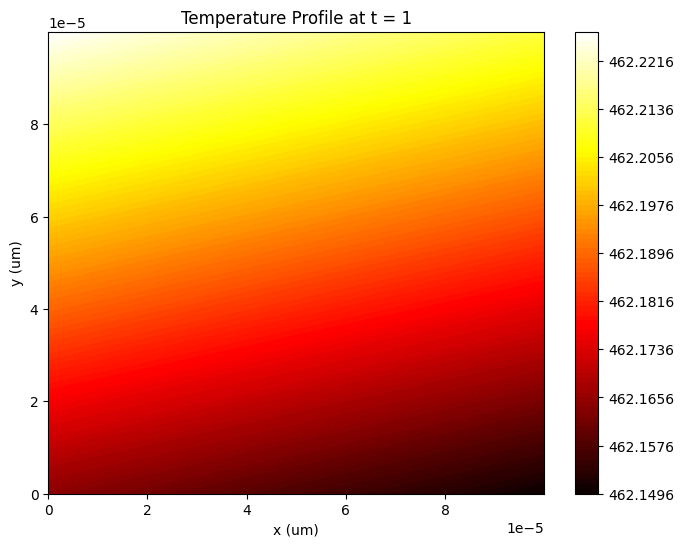

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
class PhysicsInformedNN():
    def __init__(self, X_f):
        # Extracting points x_f, y_f, t_f from X_f
        self.x_f = torch.tensor(X_f[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True).to(device)
        self.y_f = torch.tensor(X_f[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True).to(device)
        self.t_f = torch.tensor(X_f[:, 2].reshape(-1, 1), dtype=torch.float32, requires_grad=True).to(device)
        self.t_ic = torch.zeros((X_f.shape[0],1), dtype=torch.float32, requires_grad=True).to(device)
        
        # Sample true temperature values (for demonstration purposes, using a simple function)
        self.T_true = torch.ones_like(self.t_ic).to(device) * 298  # Ambient temperature in Kelvin

        # Physical constants (example values)
        self.rho = 3730
        self.Cp = 830
        self.k = 33
        self.A = 0.1  # Absorptivity, example value
        self.P = 210  # Power, example value
        self.rb = 20e-6  # Beam radius, example value
        self.iter = 0

        
        
        # Initialize the neural network
        self.create_net()
        self.optimizer = optim.Adam(self.net.parameters(), lr=1e-3)
        self.optimizer1 = torch.optim.LBFGS(self.net.parameters(),
                                    lr=1e-5,
                                    max_iter=50000,
                                    max_eval=50000,
                                    history_size=100,
                                    tolerance_grad=1e-05,
                                    tolerance_change=0.5 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")

    def create_net(self):
        self.net = nn.Sequential(
            nn.Linear(3, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 1)
        ).to(device)

    def net_T(self, x, y, t):
        T = self.net(torch.hstack((x, y, t)))
        return T

    def physics_loss(self, x, y, t):
        # Define the heat source Q_laser
        Q_laser = (2 * self.A * self.P / (torch.pi * self.rb**2)) * torch.exp(-2 * (x**2 + (y-100e-6)**2) / self.rb**2)
        
        T = self.net_T(x, y, t)
        T_x = torch.autograd.grad(T, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        T_y = torch.autograd.grad(T, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        T_t = torch.autograd.grad(T, t, grad_outputs=torch.ones_like(T), create_graph=True)[0]

        T_xx = torch.autograd.grad(T_x, x, grad_outputs=torch.ones_like(T_x), create_graph=True)[0]
        T_yy = torch.autograd.grad(T_y, y, grad_outputs=torch.ones_like(T_y), create_graph=True)[0]

        # Ensure Q_laser has the same shape as T_t for proper broadcasting
        Q_laser = Q_laser.unsqueeze(1)  # Ensure Q_laser is column vector for broadcasting
        
        heat_eq = self.rho * self.Cp * T_t - self.k * (T_xx + T_yy) - Q_laser
        loss_pde = torch.mean(heat_eq ** 2)

        return loss_pde

    def total_loss(self):
        loss_data = torch.mean((self.net_T(self.x_f, self.y_f, self.t_ic) - self.T_true) ** 2)
        loss_pde = self.physics_loss(self.x_f, self.y_f, self.t_f)
        return loss_data + loss_pde

    def train(self, epochs=500000):
        self.net.train()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            loss_ic = torch.mean((self.net_T(self.x_f, self.y_f, self.t_ic) - self.T_true) ** 2)
            loss_pde = self.physics_loss(self.x_f, self.y_f, self.t_f)
            loss = loss_ic + loss_pde
            loss.backward()
            self.optimizer.step()

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Total Loss: {loss}  loss_ic: {loss_ic} loss_pde: {loss_pde} device: {device}')

    def closure(self):
        self.optimizer1.zero_grad()
        loss = self.total_loss()
        loss.backward()
        # self.optimizer1.step()
        self.iter+=1

        if self.iter % 100 == 0:
            print(f'Epoch {self.iter}, Loss: {loss.item()} device: {device}')
        
        return loss
    
    def train1(self):
        self.net.train()
        self.optimizer1.step(self.closure)

    def predict(self, x, y, t):
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(next(self.parameters()).device)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(next(self.parameters()).device)
        t_tensor = torch.tensor(t, dtype=torch.float32).unsqueeze(1).to(next(self.parameters()).device)
        T = self.net_T(x_tensor, y_tensor, t_tensor).cpu().detach().numpy()
        return T

    def plot_heatmap(self, domain_size = 100e-6):
        x_plot = torch.linspace(0, domain_size, 100).to(device).unsqueeze(1)
        y_plot = torch.linspace(0, domain_size, 100).to(device).unsqueeze(1)
        t_plot = torch.tensor([[1]]).to(device)  # fixed time for 2D plot

        X, Y = torch.meshgrid(x_plot.squeeze(), y_plot.squeeze())
        X = X.flatten().unsqueeze(1)
        Y = Y.flatten().unsqueeze(1)
        T = t_plot.repeat(X.shape[0], 1)

        with torch.no_grad():
            T_pred = self.net_T(X, Y, T).cpu().numpy().reshape(100, 100)

        plt.figure(figsize=(8, 6))
        plt.contourf(X.cpu().numpy().reshape(100, 100), Y.cpu().numpy().reshape(100, 100), T_pred, 100, cmap='hot')
        plt.colorbar()
        plt.title('Temperature Profile at t = 1')
        plt.xlabel('x (um)')
        plt.ylabel('y (um)')
        plt.show()

    def save_model(self, file_path):
        torch.save(self.net.state_dict(), file_path)

    def load_model(self, file_path):
        self.net.load_state_dict(torch.load(file_path))


if __name__ == "__main__":
    domain_size_star = 100e-6
    N_F = 3000  # Number of points for training
    x_f = np.random.uniform(0, domain_size_star, (N_F, 1))
    y_f = np.random.uniform(0, domain_size_star, (N_F, 1))
    t_f = np.random.uniform(0, 1, (N_F, 1))  # Assuming t_star_max is 5e-6
    X_f = np.hstack((x_f, y_f, t_f))
    pinn = PhysicsInformedNN(X_f)
    pinn.train()
    pinn.save_model('model2.pth')
    pinn.plot_heatmap()
